# Product Sentiment Analysis


In this notebook we will be doing sentiment classification in python using Classical ML techniques:
1. LOGISTIC REGRESSION (Implemented)
2. LSTM(To be Done)
3. LLM(To be Done)

# Step 0. Read in Data

In [129]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use('ggplot')

import nltk # type: ignore

In [130]:
# Read in data
column_names = ['Review_UID', 'Product', 'Sentiment', 'Review']
df = pd.read_csv('../data/raw/training.csv',header=None,names=column_names)

print(df.shape)
df.info()

(74682, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  74682 non-null  int64 
 1   Product     74682 non-null  object
 2   Sentiment   74682 non-null  object
 3   Review      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [131]:
df.describe()

,Review_UID
count,74682.000000
mean,6432.586165
std,3740.427870
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


## Quick EDA

In [132]:
# Type of column B before converting
print("Type of column B before converting: ", df['Review'].dtype)

# Convert column 'B' from object to string
df['Review'] = df['Review'].astype("string")
# Type of column B after converting
print("Type of column Review after converting: ", df['Review'].dtype)

Type of column B before converting:  object
Type of column Review after converting:  string


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  74682 non-null  int64 
 1   Product     74682 non-null  object
 2   Sentiment   74682 non-null  object
 3   Review      73996 non-null  string
dtypes: int64(1), object(2), string(1)
memory usage: 2.3+ MB


In [103]:
#df['Review_wordCount'] = df['Review'].apply(lambda x : len(x.split()))
#df['Review_charCount'] = df['Review'].apply(lambda x : len(x))


In [104]:
df

,Review_UID,Product,Sentiment,Review
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


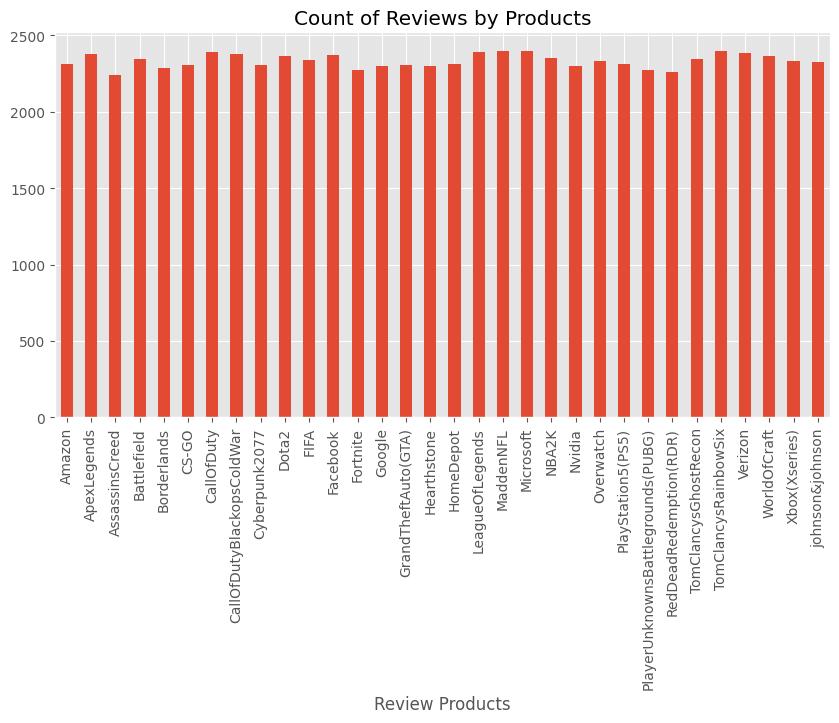

In [134]:
ax = df['Product'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Products',
          figsize=(10, 5))
ax.set_xlabel('Review Products')
plt.show()

# Step 1. Data Cleaning
### Steps of preprocessing
##### 1. Normalization
#####   converting all text to the same case (upper or lower), removing punctuation, converting numbers to their word equivalents, and so on. Normalization puts all words on equal footing, and allows processing to proceed uniformly.
#####       set all characters to lowercase
#####       remove numbers (or convert numbers to textual representations)
#####       remove punctuation (generally part of tokenization, but still worth keeping in mind at this stage, even as confirmation)
#####       strip white space (also generally part of tokenization)
#####       remove default stop words (general English stop words)
##### Broadly:
#####   a. Stemming
#####   b. lemmitization
#####   c. everything else, 
##### 2. Noise Removal
##### 3. Tokenization
#####   


In [135]:
### Checking Missing values in the Data Set and printing the Percentage for Missing Values for Each Columns ###

count = df.isnull().sum().sort_values(ascending=False)
percentage = ((df.isnull().sum()/len(df)*100)).sort_values(ascending=False)
missing_data = pd.concat([count, percentage], axis=1,
keys=['Count','Percentage'])

print('Count and percentage of missing values for the columns:')

missing_data

Count and percentage of missing values for the columns:


,Count,Percentage
Review,686,0.918561
Review_UID,0,0.000000
Product,0,0.000000
Sentiment,0,0.000000


In [136]:
print(df.shape)
df.info()

(74682, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  74682 non-null  int64 
 1   Product     74682 non-null  object
 2   Sentiment   74682 non-null  object
 3   Review      73996 non-null  string
dtypes: int64(1), object(2), string(1)
memory usage: 2.3+ MB


In [137]:
#Drop Rows with null columns
df.dropna(subset=['Review'], inplace=True)
# reset index just to be safe
df = df.reset_index(drop=True)

In [138]:
print(df.shape)
df.info()

(73996, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73996 entries, 0 to 73995
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  73996 non-null  int64 
 1   Product     73996 non-null  object
 2   Sentiment   73996 non-null  object
 3   Review      73996 non-null  string
dtypes: int64(1), object(2), string(1)
memory usage: 2.3+ MB


In [139]:
df = df.drop_duplicates()

In [140]:
print(df.shape)
df.info()

(71656, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 71656 entries, 0 to 73995
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  71656 non-null  int64 
 1   Product     71656 non-null  object
 2   Sentiment   71656 non-null  object
 3   Review      71656 non-null  string
dtypes: int64(1), object(2), string(1)
memory usage: 2.7+ MB


Percentage for default

Sentiment
Negative      30.28
Positive      27.51
Neutral       24.71
Irrelevant    17.50
Name: proportion, dtype: float64


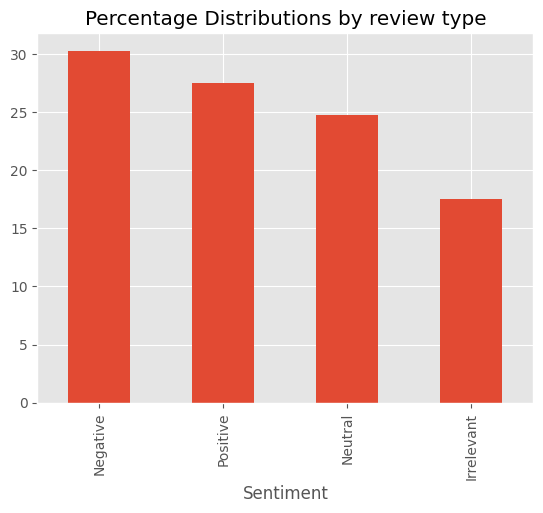

In [141]:
### Checking for the Distribution of Default ###
import matplotlib.pyplot as plt
%matplotlib inline
print('Percentage for default\n')
print(round(df.Sentiment.value_counts(normalize=True)*100,2))
round(df.Sentiment.value_counts(normalize=True)*100,2).plot(kind='bar')
plt.title('Percentage Distributions by review type')
plt.show()

# Visualizing Sentiments

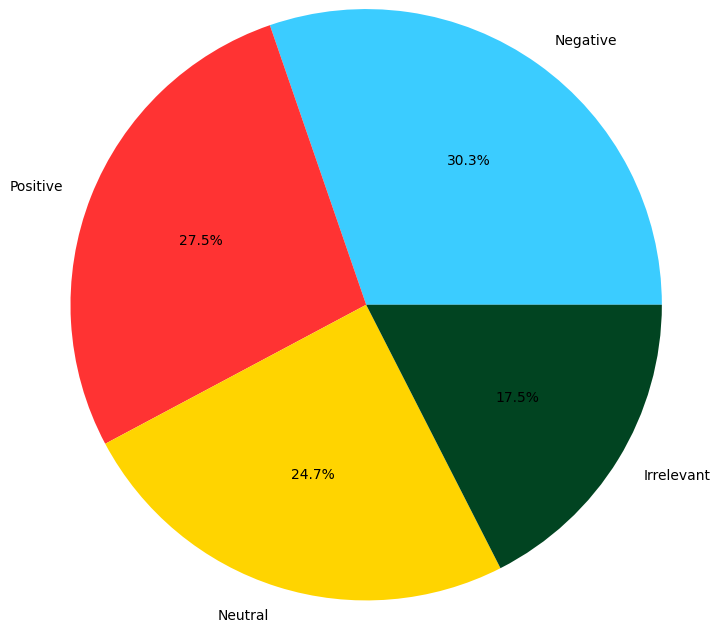

In [142]:
scores = df['Sentiment'].value_counts()

plt.pie(df['Sentiment'].value_counts(), 
        labels=scores.index, 
        autopct='%1.1f%%', 
        radius=2, 
        colors=['#3bccff','#ff3333', '#ffd400','#014421'])
plt.show()

In [143]:
# Apply Preprocessing
import nltk
import re
from nltk.corpus import stopwords
#from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string
import emoji
nltk.download('stopwords')
nltk.download('wordnet')

stemmer = nltk.SnowballStemmer('english')
#stemmer = nltk.porter.PorterStemmer()
stopwords = set(stopwords.words('english'))
# Intilize Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

#This function converts to lower-case, removes square bracket, removes numbers and punctuation
def text_normalize_basic(text):
    #Basics
    text = text.lower() # transform text to lowercase
    text = re.sub('\[.*?\]', '', text) # remove '[]' and words in it
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove links
    text = re.sub('<.*?>+', '', text) # remove '<>' and words in it
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  #remove punctuation
    text = re.sub('[‘’“”…]', '', text) # remove "" and words in it
    text = re.sub('\n', '', text) # remove line feeds
    text = re.sub('\w*\d\w*', '', text) # remove numbers and words with numbers
    # Remove Stopwords
    text = [word for word in text.split(' ') if word not in stopwords] # remove stopwords
    text=" ".join(text) # put words back together to form a text
    return text
def text_normalize_stemming(text):
    
    text = [stemmer.stem(word) for word in text.split(' ')] # stem the text
    text=" ".join(text) # put words back together to form a text
    return text
def text_normalize_emoji(text):

    # Custom processing
    text= emoji.demojize(text, delimiters=("", ""))
    return text
def text_normalize_lemmmatize(text):
    
    #Lemmatization
    # Apply 
    text = " ".join([wordnet_lemmatizer.lemmatize(word , pos='v') for word in text.split(' ')])
    return text

cleaned = lambda x: text_normalize_basic(x)
stemmed = lambda x: text_normalize_stemming(x)
emojised = lambda x: text_normalize_emoji(x)
lemmatized = lambda x: text_normalize_lemmmatize(x)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vbiswas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vbiswas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [144]:
# Let's take a look at the updated text
df['cleaned_review'] = pd.DataFrame(df.Review.apply(cleaned))
df.head(50)

,Review_UID,Product,Sentiment,Review,cleaned_review
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderlands murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hours making something fun dont know h...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,spent couple hours something fun dont know im ...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,spent hours something fun dont know im huge b...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hours making something fun dont know h...


In [116]:
# Let's take a look at the updated text
df['stemmed_review'] = pd.DataFrame(df.cleaned_review.apply(stemmed))
df.head(50)

,Review_UID,Product,Sentiment,Review,cleaned_review,stemmed_review
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderlands murder,im get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill,im get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder,im come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder,im get borderland murder
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder,im get borderland murder
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hours making something fun dont know h...,spent hour make someth fun dont know huge bo...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,spent couple hours something fun dont know im ...,spent coupl hour someth fun dont know im huge ...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,spent hours something fun dont know im huge b...,spent hour someth fun dont know im huge borde...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hours making something fun dont know h...,spent hour make someth fun dont know huge rh...


In [117]:
# Let's take a look at the updated text
df['lemmatized_review'] = pd.DataFrame(df.stemmed_review.apply(lemmatized))
df.head(50)

,Review_UID,Product,Sentiment,Review,cleaned_review,stemmed_review,lemmatized_review
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderlands murder,im get borderland murder,im get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill,come border kill,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill,im get borderland kill,im get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder,im come borderland murder,im come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder,im get borderland murder,im get borderland murder
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder,im get borderland murder,im get borderland murder
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hours making something fun dont know h...,spent hour make someth fun dont know huge bo...,spend hour make someth fun dont know huge bo...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,spent couple hours something fun dont know im ...,spent coupl hour someth fun dont know im huge ...,spend coupl hour someth fun dont know im huge ...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,spent hours something fun dont know im huge b...,spent hour someth fun dont know im huge borde...,spend hour someth fun dont know im huge borde...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hours making something fun dont know h...,spent hour make someth fun dont know huge rh...,spend hour make someth fun dont know huge rh...


In [145]:
# Let's take a look at the updated text
#df['emojised_review'] = pd.DataFrame(df.lemmatized_review.apply(emojised))
df_processed = df[["Review_UID","Product","Sentiment","cleaned_review"]]
df_processed.to_csv('../data/processed/training.csv')
df_processed.head(50)

,Review_UID,Product,Sentiment,cleaned_review
0,2401,Borderlands,Positive,im getting borderlands murder
1,2401,Borderlands,Positive,coming borders kill
2,2401,Borderlands,Positive,im getting borderlands kill
3,2401,Borderlands,Positive,im coming borderlands murder
4,2401,Borderlands,Positive,im getting borderlands murder
5,2401,Borderlands,Positive,im getting borderlands murder
6,2402,Borderlands,Positive,spent hours making something fun dont know h...
7,2402,Borderlands,Positive,spent couple hours something fun dont know im ...
8,2402,Borderlands,Positive,spent hours something fun dont know im huge b...
9,2402,Borderlands,Positive,spent hours making something fun dont know h...


## Model training 

In [148]:
from sklearn.model_selection import train_test_split

Independent_var = df.cleaned_review
Dependent_var = df.Sentiment

IV_train, IV_test, DV_train, DV_test = train_test_split(Independent_var, Dependent_var, test_size = 0.2, random_state = 225)

print('IV_train :', len(IV_train))
print('IV_test  :', len(IV_test))
print('DV_train :', len(DV_train))
print('DV_test  :', len(DV_test))

IV_train.to_csv(f'../data/interim/X_train.csv', index=False)
IV_test.to_csv(f'../data/interim/X_test.csv', index=False)
DV_train.to_csv(f'../data/interim/y_train.csv', index=False)
DV_test.to_csv(f'../data/interim/y_test.csv', index=False)


IV_train : 57324
IV_test  : 14332
DV_train : 57324
DV_test  : 14332


In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tvec = TfidfVectorizer()
clf2 = LogisticRegression(solver = "lbfgs")


from sklearn.pipeline import Pipeline

In [151]:
model = Pipeline([('vectorizer',tvec),('classifier',clf2)])

model.fit(IV_train, DV_train)

import pickle
with open(f'../data/external/model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("\n logistic regression classifier is trained on sentiment data and saved to PV location ../external/model.pkl ----")

from sklearn.metrics import confusion_matrix

predictions = model.predict(IV_test)

confusion_matrix(predictions, DV_test)


 logistic regression classifier is trained on sentiment data and saved to PV location ../external/model.pkl ----


array([[1650,  118,  156,  150],
       [ 264, 3575,  336,  318],
       [ 289,  362, 2659,  407],
       [ 310,  263,  383, 3092]])

# Model Prediction 

In [152]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy : ", accuracy_score(predictions, DV_test))
print("Precision : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy :  0.7658386826681551
Precision :  0.7698486282821636
Recall :  0.7658386826681551


In [123]:
example = ["The professional dota 2 scene is fucking exploding and I completely welcome it."]
result = model.predict(example)

print(result)

['Positive']
